# Validation of the PyPSA-Earth Installed capacity

This notebooks investigates the data quality of the African electric consumption
data by comparing PyPSA, official Nigerian and [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Africa.
To do so, please set ``countries = ["Africa"]`` in the ``config.yaml`` file.

Note. An unoptimized prepared network is sufficient for this notebook. 

## Preparation

### Import packages

In [1]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

### Set main directory to root folder

In [2]:
# change current directory
import os
import sys

#module_path = os.path.abspath(os.path.join('../../../')) # To import helpers
#if module_path not in sys.path:
    #sys.path.append(module_path+"/pypsa-earth/scripts")
    
#from _helpers import sets_path_to_root, country_name_2_two_digits, two_digits_2_name_country
#import _helpers.py

#sets_path_to_root("pypsa-earth-project")

## 1. Load data 

#### IRENA data
Retrieved from [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle2.px/).\
Please, download the statistics for 2020 for all the world and specify the url specified above, saving it to pypsa-earth-project/documentation, and changing the file name in the script to match the downloaded file.

In [2]:
year_select = 2021

IRENA_path = "C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/documentation/ELECCAP_Bolivia_2021.csv" # change path to match downloaded file
df_irena = pd.read_csv(IRENA_path, skiprows=2, encoding="latin-1")

df_irena = df_irena[df_irena.loc[:, "Year"] == year_select]
df_irena = df_irena.iloc[:, [0, 1, 2, 4]]
# df = df[df["iso_code"].notna()]  # removes antartica
df_irena = df_irena[df_irena["Country/area"] == "Bolivia (Plurinational State of)"]
display(df_irena)
# electricity_demand_owid = df
# electricity_demand_owid.tail(2)

,Country/area,Technology,Grid connection,Installed electricity capacity (MW)
0,Bolivia (Plurinational State of),Solar photovoltaic,On-grid,165.08
1,Bolivia (Plurinational State of),Solar thermal energy,On-grid,0.00
2,Bolivia (Plurinational State of),Onshore wind energy,On-grid,127.80
3,Bolivia (Plurinational State of),Offshore wind energy,On-grid,0.00
4,Bolivia (Plurinational State of),Renewable hydropower,On-grid,734.84
5,Bolivia (Plurinational State of),Mixed Hydro Plants,On-grid,0.00
6,Bolivia (Plurinational State of),Pumped storage,On-grid,0.00
7,Bolivia (Plurinational State of),Marine energy,On-grid,0.00
8,Bolivia (Plurinational State of),Solid biofuels,On-grid,72.00
9,Bolivia (Plurinational State of),Renewable municipal waste,On-grid,0.00


#### PyPSA generator data

Loads the PyPSA generators data

##### Load data from the network and create normalized dataframe

In [3]:
addelectricity_network_path = "C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/networks/elec.nc"
pypsa_network = pypsa.Network(addelectricity_network_path)

# statistics of non-storage units
installed_capacity_nostorages = pypsa_network.generators.copy()
# add country column
installed_capacity_nostorages["alpha2"] = installed_capacity_nostorages.bus.map(
    lambda x: pypsa_network.buses.country.loc[x]
)
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["ror"]), "carrier"
] = "hydro"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "onwind", "carrier"
] = "onshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["offwind-ac", "off-shore-dc"]),
    "carrier",
] = "offshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["CCGT", "OCGT"]), "carrier"
] = "gas"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "onwind", "carrier"
] = "wind"
installed_capacity_nostorages_select = installed_capacity_nostorages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]

# statistics of storage units
installed_capacity_storages = pypsa_network.storage_units.copy()
# add country column
installed_capacity_storages["alpha2"] = installed_capacity_storages.bus.map(
    lambda x: pypsa_network.buses.country.loc[x]
)
installed_capacity_storages.loc[
    installed_capacity_storages["carrier"] == "PHS", "carrier"
] = "hydro"
installed_capacity_storages_select = installed_capacity_storages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]


installed_capacity_raw = pd.concat(
    [installed_capacity_storages_select, installed_capacity_nostorages_select]
)
installed_capacity = installed_capacity_raw.groupby(["alpha2", "carrier"])[
    "p_nom"
].sum()
installed_capacity.groupby("carrier").sum().sum()

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


3157.9898286757257

##### Load PyPSA powerplant data to crosscheck data from the network

In [5]:
powerplants_data = "C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/resources/powerplants_old.csv"
available_generators = pd.read_csv(powerplants_data)
installed_capacity_resources = available_generators.groupby(["Country", "Fueltype"])[
    "Capacity"
].sum()
#display(available_generators)
capacity_pypsa_fueltype = installed_capacity_resources.groupby(["Fueltype"]).sum()
display(capacity_pypsa_fueltype)
display(capacity_pypsa_fueltype.sum())

Fueltype
Bioenergy      65.58
CCCGT         311.41
CCGT         1029.05
OCGT          948.92
Oil            31.32
Solar         164.90
Wind          127.34
hydro         732.20
Name: Capacity, dtype: float64

3410.7199999999993

# 2. Validate

#### Steps:
- Specify year of interest of the IRENA dataset and the countries of interest
- Harmonize IRENA dataset to the PyPSA standard
- Align dataframe naming and temporal resolution
- Merge dataframe


##### Specify year of the analysis and the countries of interest

In [6]:
year_owid = 2021  # option
country_list = installed_capacity_nostorages.alpha2.unique()
country_list

array(['BO'], dtype=object)

##### Process IRENA data to match PyPSA standard

In [7]:
# copy IRENA dataset
df = df_irena.copy()

# Process technologies
df.loc[
    df["Technology"].isin(["Solar photovoltaic", "Solar thermal energy"]), "Technology"
] = "solar"
df.loc[df["Technology"].isin(["Onshore wind energy"]), "Technology"] = "onshore wind"
df.loc[df["Technology"].isin(["Offshore wind energy"]), "Technology"] = "offshore wind"
df.loc[
    df["Technology"].isin(
        ["Renewable hydropower", "Mixed Hydro Plants", "Pumped storage"]
    ),
    "Technology",
] = "hydro"
df.loc[
    df["Technology"].isin(["Other non-renewable energy", "Marine energy"]), "Technology"
] = "other"
df.loc[
    df["Technology"].isin(["Liquid biofuels", "Biogas", "Solid biofuels"]), "Technology"
] = "bioenergy"
df.loc[df["Technology"].isin(["Geothermal energy"]), "Technology"] = "geothermal"
df.loc[df["Technology"].isin(["Natural gas"]), "Technology"] = "gas"
df.loc[df["Technology"].isin(["Renewable municipal waste"]), "Technology"] = "waste"
df.loc[df["Technology"].isin(["Coal and peat"]), "Technology"] = "coal"
df.loc[df["Technology"].isin(["Oil", "Fossil fuels n.e.s."]), "Technology"] = "oil"

display(df)

# df = df[df.alpha2.isin(country_list)]
# df["p_nom"] = pd.to_numeric(
#     df["Installed electricity capacity by country/area (MW)"], errors="coerce"
# )
installed_capacity_irena = (
    df.rename(columns={"Technology": "carrier", "Installed electricity capacity (MW)":"p_nom"})
    .groupby(["carrier"])["p_nom"]
    .sum()
)
installed_capacity_irena.groupby("carrier").sum()

,Country/area,Technology,Grid connection,Installed electricity capacity (MW)
0,Bolivia (Plurinational State of),solar,On-grid,165.08
1,Bolivia (Plurinational State of),solar,On-grid,0.00
2,Bolivia (Plurinational State of),onshore wind,On-grid,127.80
3,Bolivia (Plurinational State of),offshore wind,On-grid,0.00
4,Bolivia (Plurinational State of),hydro,On-grid,734.84
5,Bolivia (Plurinational State of),hydro,On-grid,0.00
6,Bolivia (Plurinational State of),hydro,On-grid,0.00
7,Bolivia (Plurinational State of),other,On-grid,0.00
8,Bolivia (Plurinational State of),bioenergy,On-grid,72.00
9,Bolivia (Plurinational State of),waste,On-grid,0.00


carrier
Nuclear             0.00
bioenergy          77.00
coal                0.00
gas              2464.45
geothermal          0.00
hydro             734.84
offshore wind       0.00
oil                31.58
onshore wind      127.80
other               0.00
solar             165.08
waste               0.00
Name: p_nom, dtype: float64

##### Include data from ministery

In [8]:
# Path to the Excel file
excel_file = "C:/Users/xenia/OneDrive/Desktop/Uni/NTNU/Thesis/Data/electricity_2006-2021.xlsx"

# Read data from a specific worksheet by name
worksheet_name = 'Validation'
df = pd.read_excel(excel_file, sheet_name=worksheet_name)
df.set_index('carrier', inplace=True)
df.index = df.index.str.capitalize()
df_official = df["p_nom"]
display(df_official)

carrier
Hydro            759
Biomass          153
Gas             2924
Onshore wind     129
Solar            172
Name: p_nom, dtype: int64

##### Merge datasets by carrier

carrier
Nuclear             0.00
Biomass            77.00
Coal                0.00
Gas              2464.45
Geothermal          0.00
Hydro             734.84
Offshore wind       0.00
Oil                31.58
Onshore wind      127.80
Other               0.00
Solar             165.08
Waste               0.00
Name: p_nom, dtype: float64

carrier
Hydro            759
Biomass          153
Gas             2924
Onshore wind     129
Solar            172
Name: p_nom, dtype: int64

,PyPSA 2021,IRENA 2021,Ministery 2021
carrier,,,
Biomass,77.230000,77.00,153.0
Gas,2268.880000,2464.45,2924.0
Hydro,732.200000,734.84,759.0
Oil,11.740000,31.58,NaN
Onshore wind,25.806506,127.80,129.0
Solar,119.113323,165.08,172.0
Nuclear,NaN,0.00,NaN
Coal,NaN,0.00,NaN
Geothermal,NaN,0.00,NaN


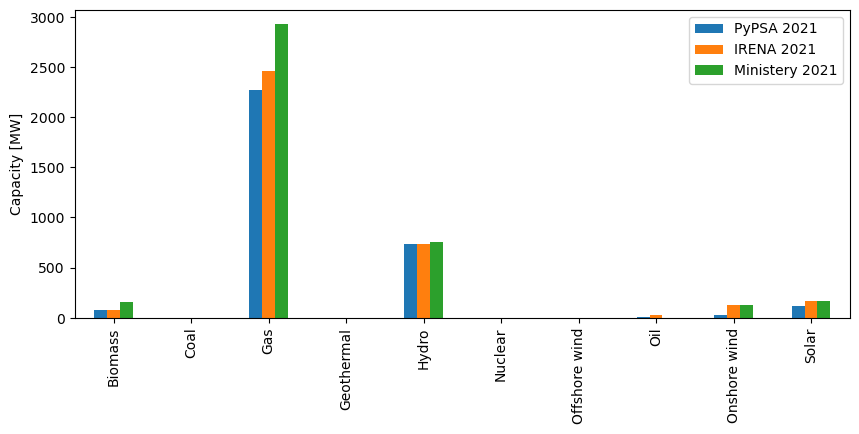

In [9]:
world_ic = installed_capacity_irena.groupby("carrier").sum() 
world_ic = world_ic.rename(index={"bioenergy": "Biomass"})

world_ic.index = world_ic.index.str.capitalize()
display(world_ic)
display(df_official)

world_pypsa = installed_capacity.groupby("carrier").sum() 
if "load" in world_pypsa.index:
    world_pypsa = world_pypsa.drop("load")
world_pypsa.index = world_pypsa.index.str.capitalize()

world_compare = pd.concat(
    [world_pypsa.rename("PyPSA 2021"), world_ic.rename("IRENA 2021"),df_official.rename("Ministery 2021")], axis=1 #, df.rename("Ministery 2021")
)
display(world_compare)
# Sorting and dropping
world_compare = world_compare.drop("Waste")
world_compare = world_compare.drop("Other")
world_compare = world_compare.sort_index()

# Plot
ax = world_compare.plot.bar(
    ylabel="Capacity [MW]", xlabel="Technology", figsize=(10, 4)
).set(xlabel=None)

# plt.savefig("capacity-validation-all.pdf", bbox_inches="tight")

[Text(0.5, 0, '')]

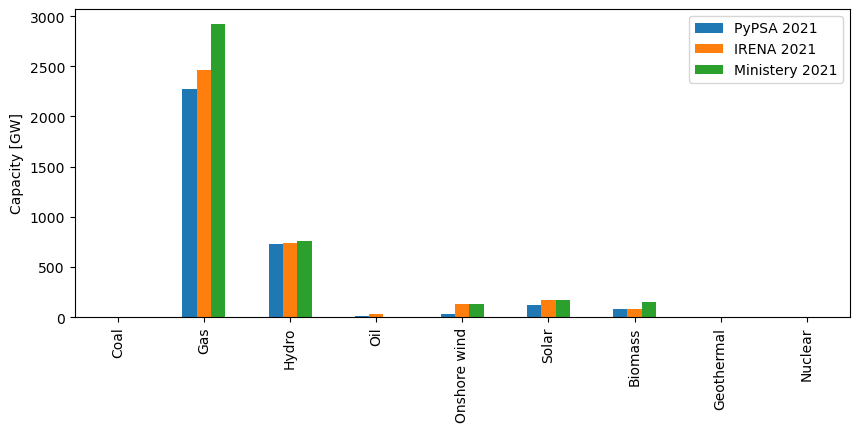

In [10]:
list_carriers = [
    "Coal",
    "Gas",
    "Hydro",
    "Oil",
    "Onshore wind",
    "Solar",
    "Biomass",
    "Geothermal",
    "Nuclear",
]

world_compare.loc[list_carriers].plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology", figsize=(10, 4)
).set(xlabel=None)

# plt.savefig("capacity-validation.pdf", bbox_inches="tight")

##### Merge dataframes by technology for specific country

According to [USAID](https://www.usaid.gov/powerafrica/nigeria), the total installed generation in Nigeria is:
- Hydro: 2.062 GW
- Gas: 11.972 GW
- Wind: 0.01 GW
- Solar: 0.007 GW
- Other/Diesel/HFO: 2.333 GW

Total: 16.384 GW

Power Africa new MW to date at financial close: 3.043 GW

In [11]:
# Get data from usaid manually
usaid_ng = pd.DataFrame(
    data=[2.062, 11.972, 0.01, 0.007, 2.333],
    index=["Hydro", "Gas", "Wind", "Solar", "Other/Diesel/HFO"],
    columns=["USAID"],
)

# Prepare data from usaid
usaid_ng.index.name = "carrier"

usaid_ng.rename(
    index={
        "Hydro": "hydro",
        "Gas": "gas",
        "Wind": "wind",
        "Solar": "solar",
        "Other/Diesel/HFO": "oil",
    },
    inplace=True,
)
print("WARNING: Other/Diesel/HFO is renamed to 'Oil'")

In [12]:
country = "NG"
country_ic = (
    installed_capacity_irena.iloc[
        installed_capacity_irena.index.get_level_values("alpha2") == country
    ]
    / 1000
)
country_pypsa = (
    installed_capacity.iloc[
        installed_capacity.index.get_level_values("alpha2") == country
    ]
    / 1000
)
country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = country_compare.index.get_level_values(1)
country_compare = pd.concat([country_compare, usaid_ng], axis=1)

KeyError: 'Requested level (alpha2) does not match index name (carrier)'

Adjust the dataframe

In [ ]:
# Rename the index according to existing graph in paper
required_index = {
    # "coal": "Coal",
    "gas": "Gas",
    "hydro": "Hydro",
    "oil": "Oil",
    "wind": "Onshore wind",
    "solar": "Solar",
    # "Nuclear": "Nuclear",
    # "bioenergy": "Bioenergy",
    # "geothermal": "Geothermal",
}

country_compare.rename(index=required_index, inplace=True)

# select only required technologies
country_compare_sel = country_compare.loc[list(required_index.values())]

NameError: name 'country_compare' is not defined

Plot the graph

In [13]:
ax = country_compare_sel.plot.bar(ylabel="Capacity [GW]", xlabel="", figsize=(10.5, 5))
# optional:save it
# ax.figure.savefig("capacity-validation-ng.pdf", bbox_inches="tight")

NameError: name 'country_compare_sel' is not defined

##### Merge dataframes by country

In [14]:
country_ic = (
    installed_capacity_irena[
        installed_capacity_irena.index.get_level_values(1)
        .str.capitalize()
        .isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)
country_pypsa = (
    installed_capacity[
        installed_capacity.index.get_level_values(1)
        .str.capitalize()
        .isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)

country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = pd.Series(
    country_compare.index.map(two_digits_2_name_country)
).replace(
    {
        "Congo, The Democratic Republic of the": "DRC",
        "Central African Republic": "CAR",
        "Tanzania, United Republic of": "Tanzania",
    }
)
plt.rcParams.update({"font.size": 20})
ax = country_compare.plot.bar(
    figsize=(20, 5), ylabel="Capacity [GW]", xlabel="Country", fontsize=20
)
ax.set(xlabel=None)

# plt.savefig("capacity-validation-by-country.pdf", bbox_inches="tight")

IndexError: Too many levels: Index has only 1 level, not 2

In [15]:
# Installed capacities of a technology by country
# df[df.Technology=="gas"].groupby("alpha2")["p_nom"].sum()
# installed_capacity_nostorages_select[installed_capacity_nostorages_select.carrier == "gas"].groupby("alpha2")["p_nom"].sum()

# SEABORN

In [16]:
# Initialize the matplotlib figure
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
world_compare = world_compare.copy()
world_compare = world_compare.reset_index()

pypsa_values = world_compare.loc[:, ["carrier", "PyPSA 2020"]]
pypsa_values.loc[:, "sources"] = "PyPSA 2020"
pypsa_values.rename(columns={"PyPSA 2020": "capacity [GW]"}, inplace=True)

irena_values = world_compare.loc[:, ["carrier", "IRENA 2020"]]
irena_values.loc[:, "sources"] = "IRENA 2020"
irena_values.rename(columns={"IRENA 2020": "capacity [GW]"}, inplace=True)

seaborn_df = pd.concat([pypsa_values, irena_values])

KeyError: "['PyPSA 2020'] not in index"

#### Calculate percentage error of technologies

In [18]:
pypsa_values.set_index("carrier")["capacity [GW]"] / irena_values.set_index("carrier")[
    "capacity [GW]"
]

carrier
Biomass                NaN
Coal                   NaN
Gas               0.605678
Geothermal             NaN
Hydro             0.902698
Nuclear                NaN
Offshore wind          NaN
Oil              27.878707
Onshore wind           inf
Solar             0.982604
Name: capacity [GW], dtype: float64

#### Plot technology map

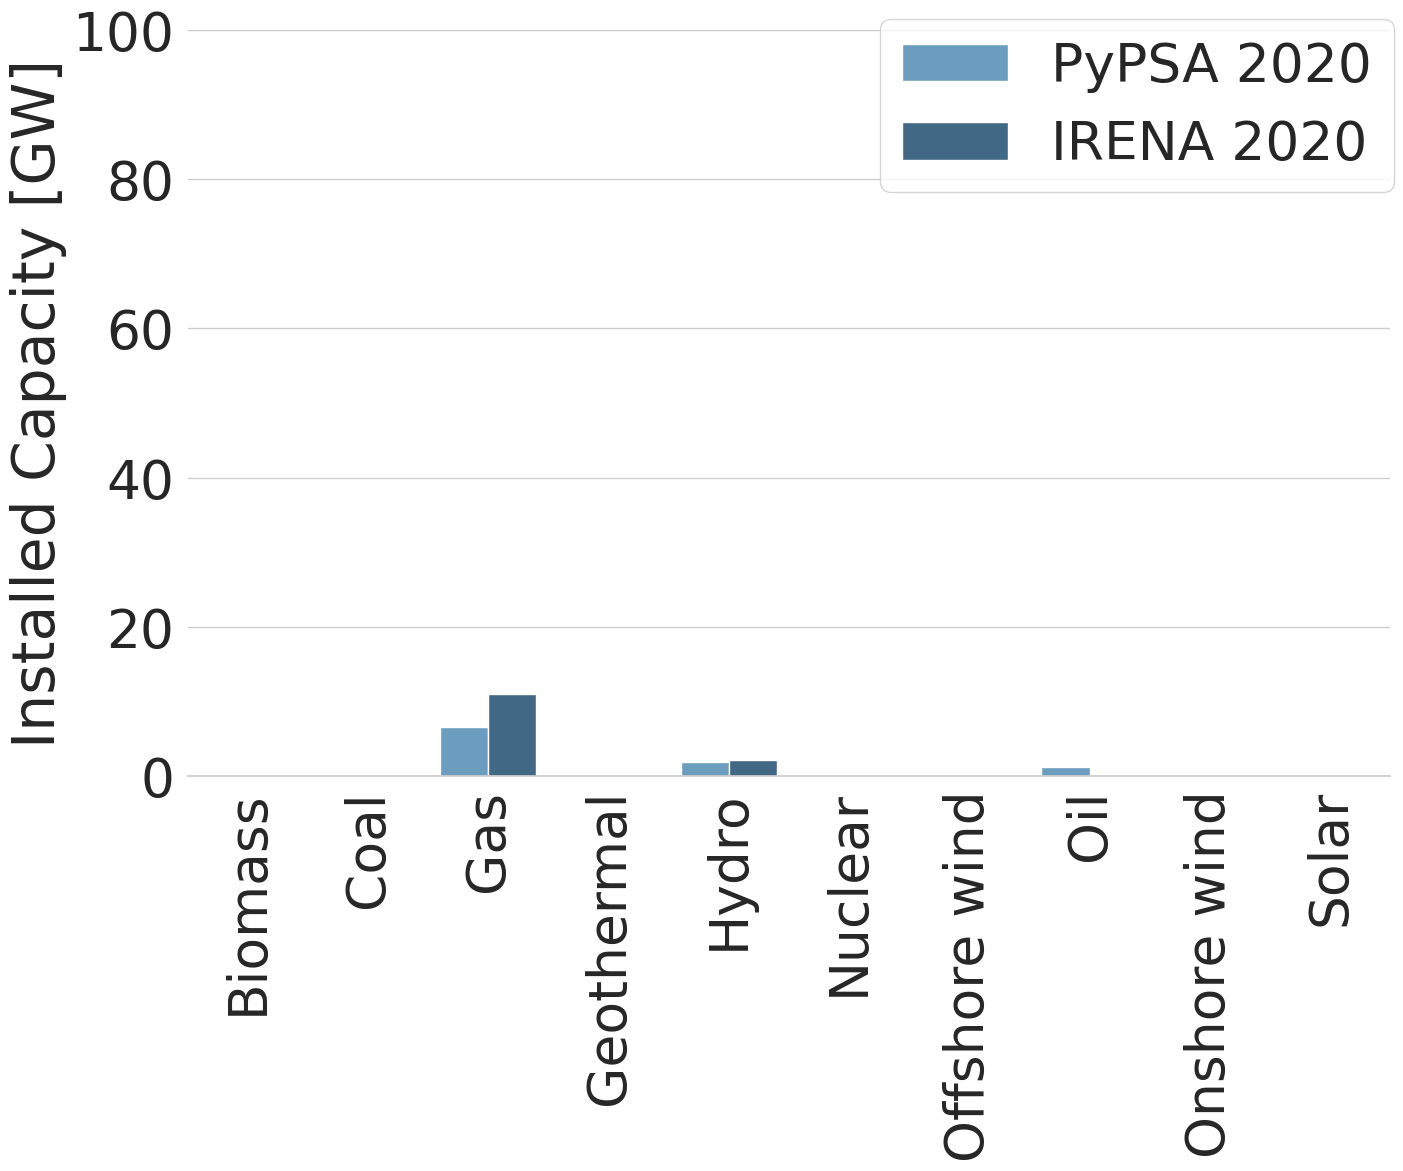

In [19]:
sns.set_theme(style="whitegrid", font_scale=3.5)

ax = sns.catplot(
    x="carrier",
    y="capacity [GW]",
    hue="sources",
    data=seaborn_df,
    palette="Blues_d",
    kind="bar",
    height=10,
    aspect=1.5,
)

ax.set_xticklabels(rotation=90)
sns.move_legend(
    ax, "upper right", bbox_to_anchor=(0.75, 0.975), frameon=True, title=None
)
sns.despine(left=True, bottom=False)
ax.set(xlabel=None, ylabel="Installed Capacity [GW]", ylim=(0, 100))

# plt.savefig("capacity-validation-all.pdf", bbox_inches="tight")

In [20]:
country_compare_sel = country_compare_sel.copy()
country_compare_sel = country_compare_sel.reset_index()

pypsa_values = country_compare_sel.loc[:, ["carrier", "PyPSA 2020"]]
pypsa_values.loc[:, "sources"] = "PyPSA 2020"
pypsa_values.rename(columns={"PyPSA 2020": "capacity [GW]"}, inplace=True)

irena_values = country_compare_sel.loc[:, ["carrier", "IRENA 2020"]]
irena_values.loc[:, "sources"] = "IRENA 2020"
irena_values.rename(columns={"IRENA 2020": "capacity [GW]"}, inplace=True)

usaid_values = country_compare_sel.loc[:, ["carrier", "USAID"]]
usaid_values.loc[:, "sources"] = "USAID 2020"
usaid_values.rename(columns={"USAID": "capacity [GW]"}, inplace=True)

seaborn_df = pd.concat([pypsa_values, irena_values, usaid_values])

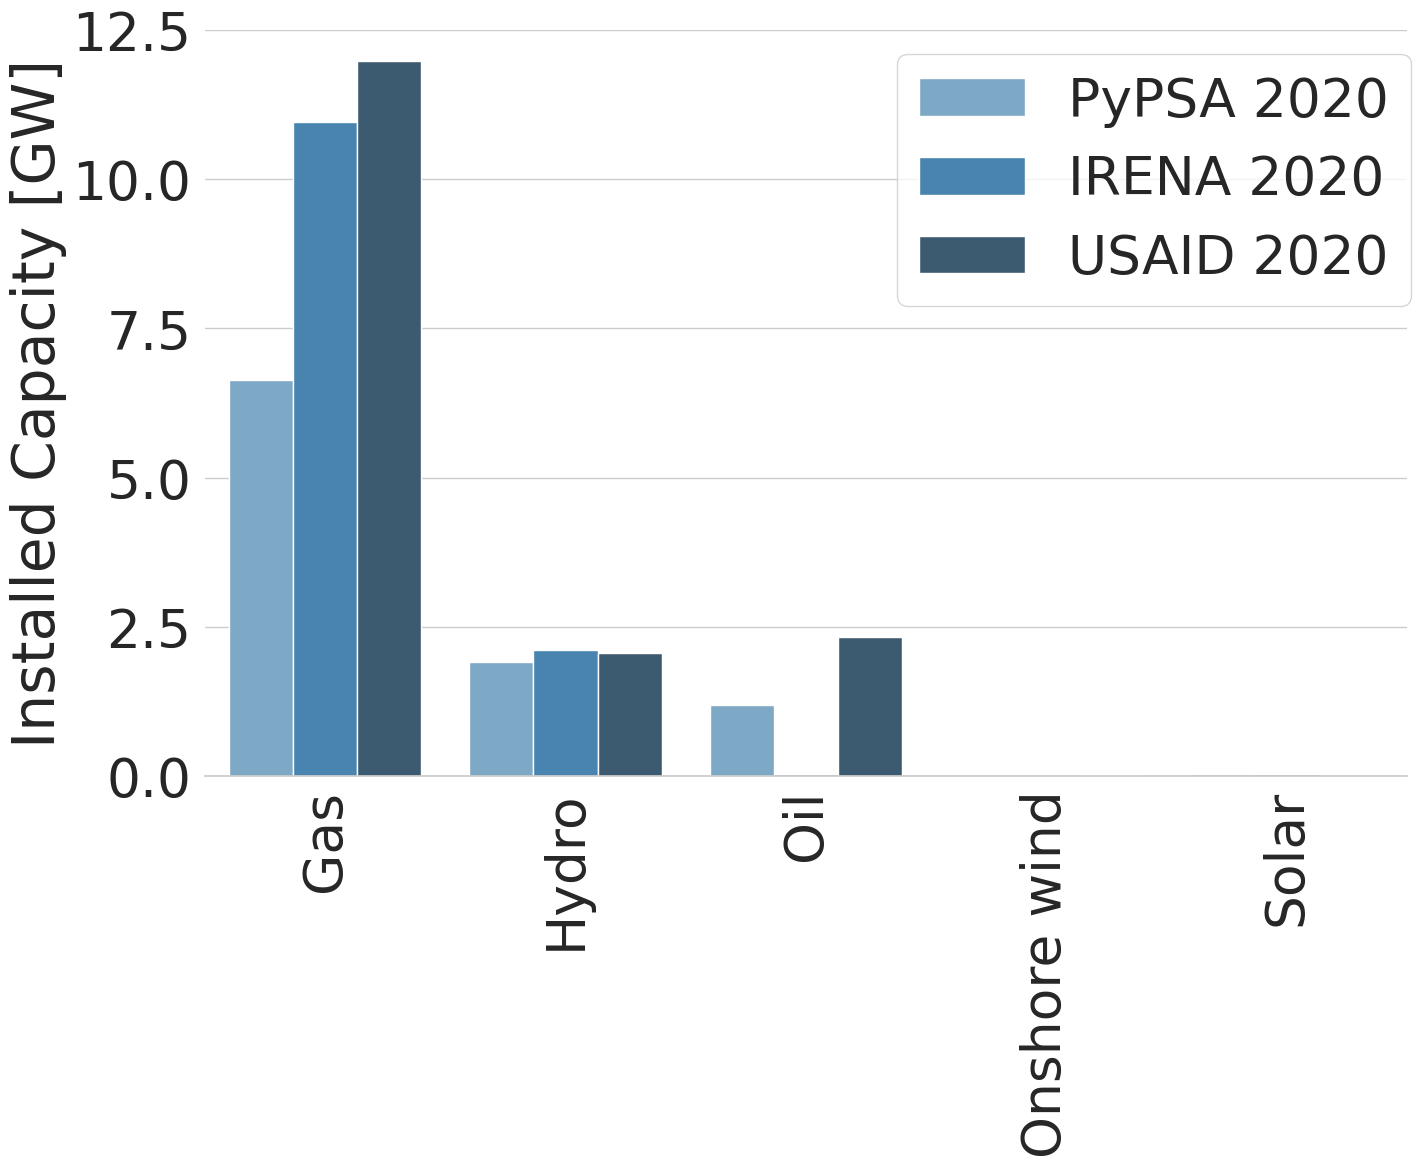

In [21]:
sns.set_theme(style="whitegrid", font_scale=3.5)

ax = sns.catplot(
    x="carrier",
    y="capacity [GW]",
    hue="sources",
    data=seaborn_df,
    palette="Blues_d",
    kind="bar",
    height=10,
    aspect=1.5,
)

ax.set_xticklabels(rotation=90)
sns.move_legend(
    ax, "upper right", bbox_to_anchor=(0.75, 0.94), frameon=True, title=None
)
sns.despine(left=True, bottom=False)
ax.set(xlabel=None, ylabel="Installed Capacity [GW]", ylim=(0, 12.5))

# plt.savefig("capacity-validation-ng.pdf", bbox_inches="tight")

In [22]:
country_compare = country_compare.copy()
country_compare = country_compare.reset_index()

pypsa_values = country_compare.loc[:, ["alpha2", "PyPSA 2020"]]
pypsa_values.loc[:, "sources"] = "PyPSA 2020"
pypsa_values.rename(columns={"PyPSA 2020": "capacity [GW]"}, inplace=True)

irena_values = country_compare.loc[:, ["alpha2", "IRENA 2020"]]
irena_values.loc[:, "sources"] = "IRENA 2020"
irena_values.rename(columns={"IRENA 2020": "capacity [GW]"}, inplace=True)

seaborn_df = pd.concat([pypsa_values, irena_values])

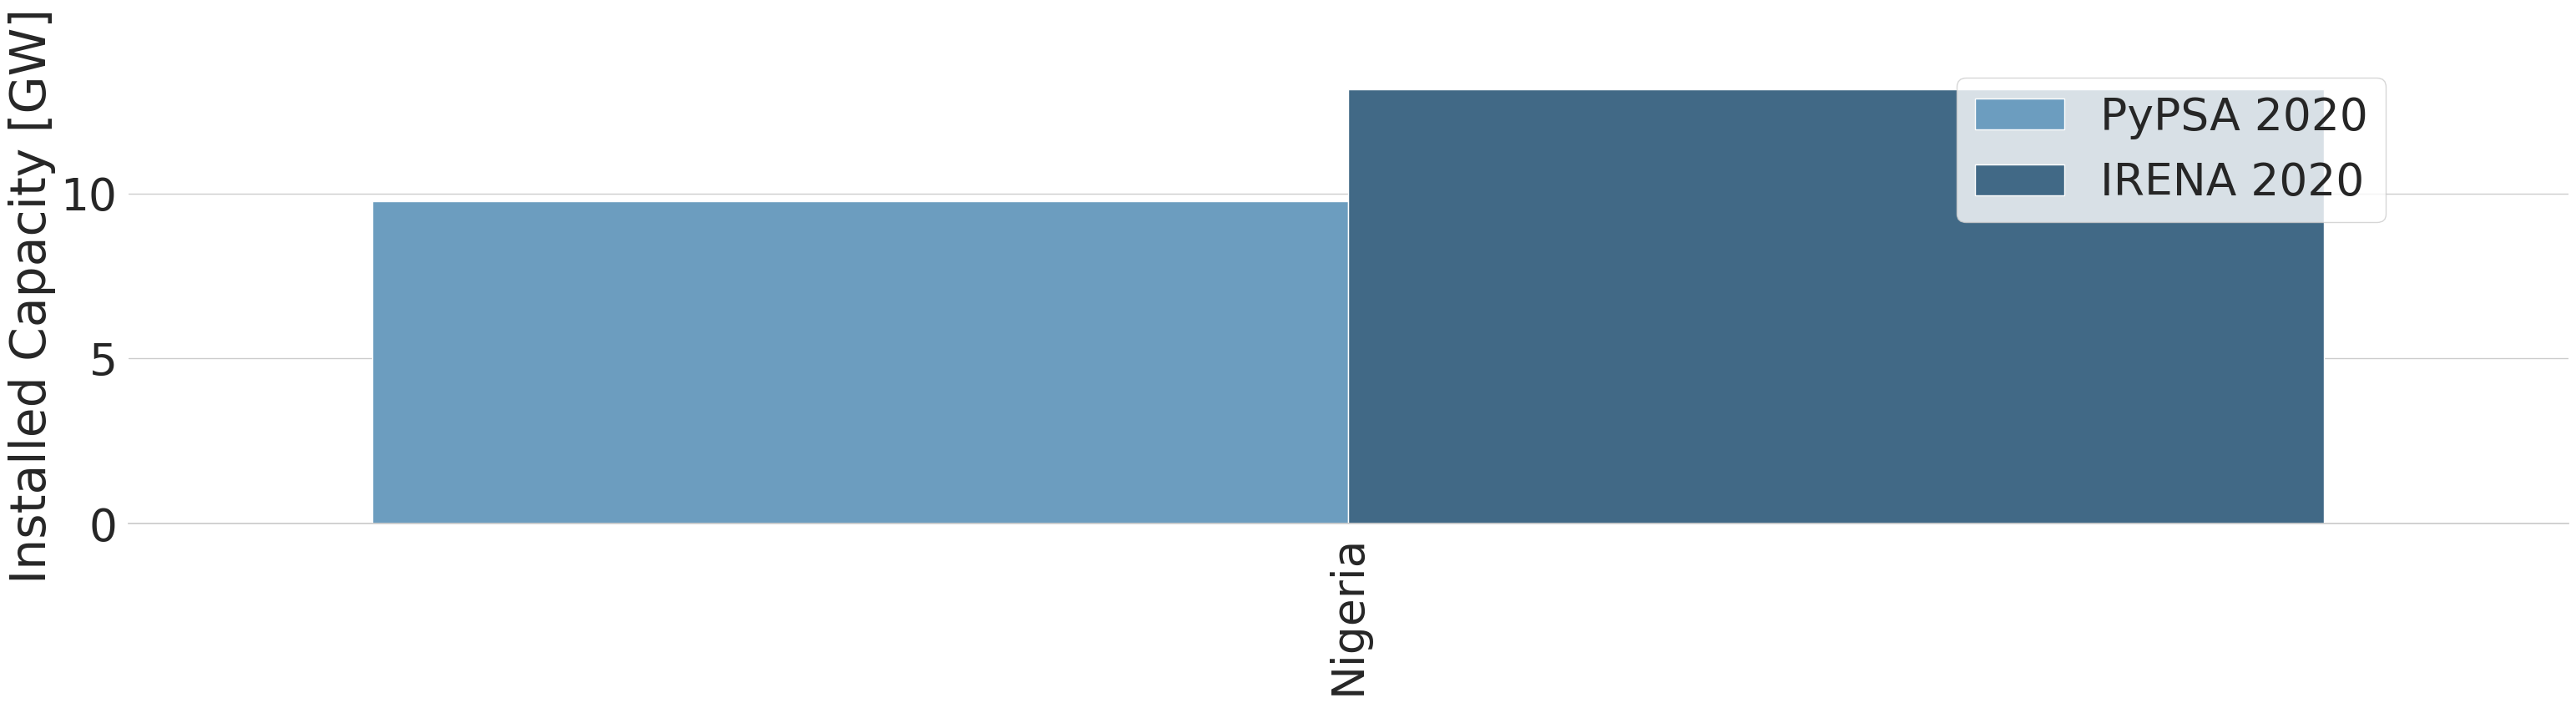

In [23]:
sns.set_theme(style="whitegrid", font_scale=3.5)

ax = sns.catplot(
    x="alpha2",
    y="capacity [GW]",
    hue="sources",
    data=seaborn_df,
    palette="Blues_d",
    kind="bar",
    height=8,
    aspect=4,
)

ax.set_xticklabels(rotation=90)
sns.move_legend(ax, "upper right", bbox_to_anchor=(0.8, 0.94), frameon=True, title=None)
sns.despine(left=True, bottom=False)
ax.set(xlabel=None, ylabel="Installed Capacity [GW]")

# plt.savefig("capacity-validation-by-country.pdf", bbox_inches="tight")